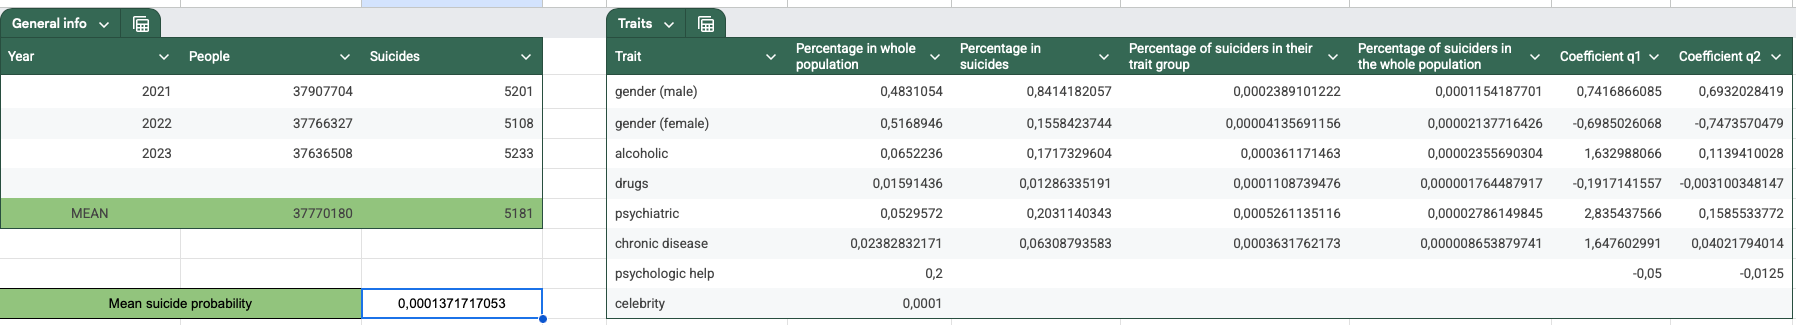

* liczba osob uzaleznionych od narkotykow na 2018 rok jest szacowana na 60k osob czyli mniej wiecej 0.015914359526600853 populacji

* liczba osob przewlekle chorych jest ciezka do ustalenia - dajemy 900k osób czyli prawie 2.38%

* liczba osob korzystajaca z pomocy psychologa - 20%

* celebrytom zostawiamy taka sama szanse na samobojstwo

Po pierwsze trzeba zdefiniować, jak będzie chcieli pogrupować społeczności (znajomych) względem agenta. Albo na sztywno robimy "patch", które będą oznaczać naszą społeczność, albo robimy jakiś clustering (ale nie brałbym wszystkich), albo jeszcze inny sposób.

Podstawowy sposób w jaki się generuje samobójstwa to bierze się wartości cech, dla każdej cechy ustala się wartość graniczną (threshold), której po przekroczeniu zwiększa się ryzyko popełnienia samobójstwa dla danej cechy. Czyli {1 - q, 1 + q}, gdzie q to ustalona wartość. 

Czyli parwdopodobieństwo popełnienia samobójstwa będzie równe 

$$ p_{new} = p_{old}\cdot\prod_{i=1}^{6}(1 \pm q_i)$$




Keywords:
- social learning

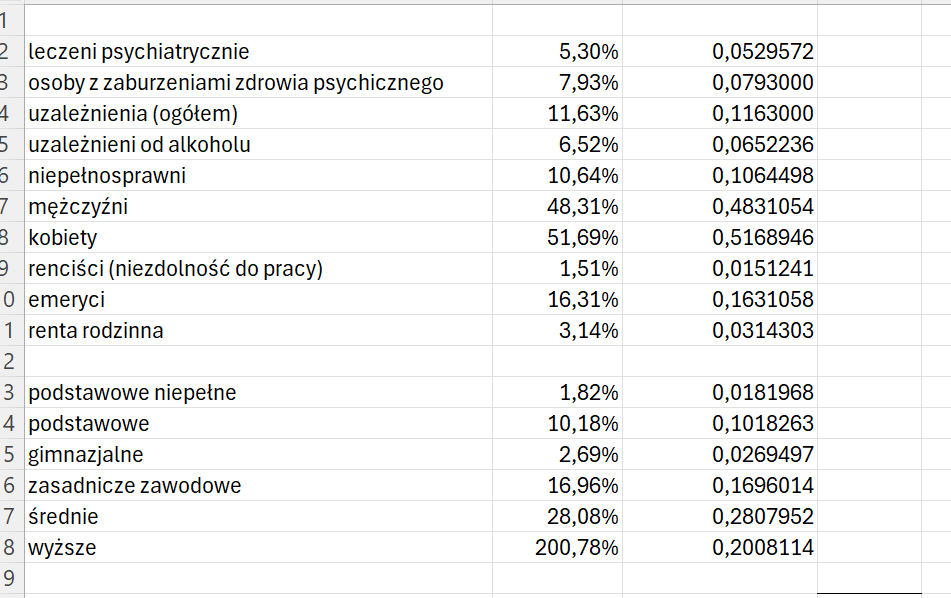

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

In [7]:
MSP = 0.0001371717053
#gender (male), alcoholic, drugs, psychiatric, chronic disease, psychologic help, celebrity
traits_prob_binary = np.array([0.4831054, 0.0652236, 0.01591436, 0.0529572, 0.02382832171, 0.2, 0.0001])
q1 = np.array([0.7416866085, 1.632988066, -0.1917141557, 2.835437566, 1.647602991, -0.05, 0])
q2 = -1 * np.array([0.6932028419, 0.1139410028, -0.003100348147, 0.1585533772, 0.04021794014, -0.0125, 0])

In [28]:
class Community:

    def __init__(self, community_population, MSP, traits_prob_binary, q1, q2, memory_time = 3):
        self.community_population = community_population     
        self.MSP = MSP  # mean suicide probability
        self.q1 = q1    # vector of influence on suicide probability if given trait==1
        self.q2 = q2    # vector of influence on suicide probability if given trait==0
        self.memory_time = memory_time
        self.patch = np.zeros(shape = (community_population, len(traits_prob_binary) + 2), dtype=object)  # community patch
        self.traits_prob_binary = traits_prob_binary
        self.new_suicides = []
        self.obituary = []
        self.world_obituary = []
        self.time = 0
        
    def _agents_stats(self):
        # stats are drawn in the begining and stay the same through the whole simulation
        # TODO dodac czynnik losowy
        # draw binary stats according to stats_prob array
        # # if stat==1 then multiply p0 by 1 + value from q1_list
        # elif stat==0 then multiply p0 by 1 - value from q2_list which is already *(-1) so 1 + value from q2_list
        suicide_prob = lambda stats: stats[0] * np.prod(1 + np.array([self.q1[i] if stat==1 else self.q2[i] for i, stat in enumerate(stats[2:])]) )
        agent = np.array([MSP/12] + [self.time] + [1 if np.random.uniform()<prob else 0 for prob in self.traits_prob_binary])
        agent[0] = suicide_prob(agent)
        return agent
    

    def _fill_community(self):
        
        # add agent to community
        self.patch[0] = self._agents_stats()
        for i in range(1,self.community_population):
            if np.random.random() < 0.3:
                self.patch[i] = self.patch[0]
            else:
                self.patch[i] = self._agents_stats()


    def _suicide_status(self, probability_of_suicide):

        suicidal_index = []
        suicidal_cele = []
        for i in range(self.community_population):

            if np.random.binomial(1,probability_of_suicide[i]) == 1:
                suicidal_index.append(i) 

                if self.patch[i][-1] == 0:
                    # :2 because [prob, time, here are stats]
                    # dodanie samobojcy do listy
                    self.obituary.append(self.patch[i][2:])
                    self.new_suicides.append(self.patch[i][2:])

                else:
                    suicidal_cele += self.patch[i][2:].tolist()
                    self.new_suicides.append(self.patch[i][2:])
        
        return suicidal_cele, suicidal_index
    

    def _copycat_suicide(self, suicidal_cele):

        if len(suicidal_cele) > 0:
            self.world_obituary += suicidal_cele
        
        suicidal = self.world_obituary
        now_prob = []
        celebrities = []

        if len(suicidal) > 0:
            for j in range(self.community_population):
                xn = []
                xs = []

                for stats in suicidal:

                    # this check if during agents life somebody commit suicide, then we check how old is suicide (in next upgrade we can delete old suicide from list)
                    if stats[0] > self.patch[j,1] and self.time - stats[1] < 3:
 
                        m = np.sum(self.patch[j, 2:] == stats[1:])
                        
                        if stats[-1] == 0:
                            # from book, the suicide of normal agents impact community have value 1.5
                            xn.append(1.01 ** (m ** 2) * 1.5)
                        else:
                            # from book, the suicide of celebrities agents impact community have value 8
                            xs.append(1.01 ** (m ** 2) * 8)

                now_prob.append(min(self.patch[j][0] * (1 + sum(xn) + sum(xs)),1)) 

        else:
            now_prob = [self.patch[_][0] for _ in range(self.community_population)]

# somebody jump?            
        celebrities, index = self._suicide_status(now_prob) 

# replace dead, new agent come up in next time (step)
        self.time += 1
        for ind in index:
            if np.random.random() < 0.3:
                self.patch[ind] = self.patch[np.random.randint(0,self.community_population)]
            else:
                self.patch[ind] = self._agents_stats()

        return celebrities, index

        
    def _simulation(self,steps):
        
        
        self._fill_community()
        celebrities_list = []
        for _ in range(steps):

            celebrity, index = self._copycat_suicide(celebrities_list)
            celebrities_list = celebrity



In [39]:
class World:

    def __init__(self, communities_count, community_population, MSP, stats):
        self.community_population = community_population
        self.communities_count = communities_count
        self.MSP = MSP
        self.stats = stats
        self.word_suicidal = np.zeros(shape = (communities_count,communities_count))
        self.communities = np.empty(shape =(communities_count,communities_count),dtype=object)
        self.celebrities_suicide = []
        self.obituary = []
    

    def __init_communities__(self):
        for i in range(self.communities_count):
            for j in range(self.communities_count):
                self.communities[i, j] = Community(community_population=self.community_population, MSP=self.MSP, traits_prob_binary=self.stats, q1=q1, q2=q2)
                self.communities[i, j]._fill_community()


    def __suicide_status__(self):
        
        podmianka = []
        for i in range(self.communities_count):
            for j in range(self.communities_count):
                celebrities, index = self.communities[i, j]._copycat_suicide(self.celebrities_suicide)
                self.word_suicidal[i,j] = len(index)
                if len(celebrities) > 0:
                    podmianka.append(celebrities)
        self.celebrities_suicide = podmianka
              
                
    def __simulation__(self,steps):
        world_in_time = []
        world_suiciders = []
        self.__init_communities__()
        for _ in range(steps):
            self.__suicide_status__()
            world_in_time.append(self.word_suicidal)
            self.word_suicidal = np.zeros_like(self.word_suicidal)
            suiciders_per_step = []

            for i in range(self.communities_count):
                for j in range(self.communities_count): 
                    suiciders_per_step.extend(self.communities[i,j].new_suicides)
                    self.communities[i,j].new_suicides = []

            world_suiciders.append(suiciders_per_step)

        return world_in_time, world_suiciders

In [40]:
T = 12*3
communities_count = 15
community_population = 1000

class1 = World(communities_count, community_population, MSP=MSP, stats=traits_prob_binary)
results1, results2 = class1.__simulation__(T)
world_final = sum(results1)

suiciders_total = np.sum(world_final)
print(f"Total number of suicides during {T} months is: {suiciders_total}")

Total number of suicides during 36 months is: 89.0


In [41]:
communities_count**2 * community_population 

225000

In [42]:
37.770*10**6 - 25**2 *60500

-42500.0

# Visualisation

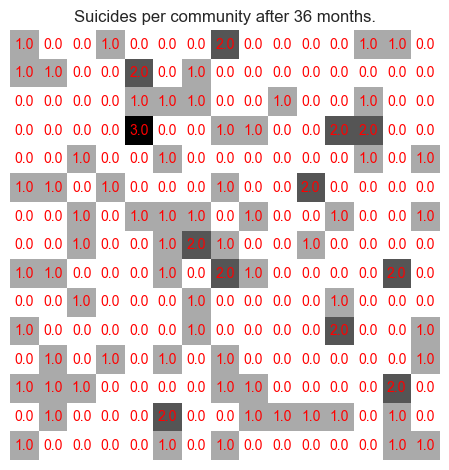

In [43]:
fig, ax = plt.subplots()
im = ax.imshow(world_final, cmap= 'binary')

# create text annotations.
for (i, j), value in np.ndenumerate(world_final):
    ax.text(j, i, str(value), ha="center", va="center", color="r")

ax.set_title(f"Suicides per community after {T} months.")
ax.axis('off')
# Add a colorbar (legend)
# cbar = fig.colorbar(im, ax=ax)
fig.tight_layout()
plt.show()

In [46]:
# Row is a number of suicides for all communities for next iterations
world_suiciders = [np.sum(row,axis=0) if row else np.zeros(7) for row in results2]
world_suiciders = np.vstack(world_suiciders)

In [47]:
column_sums = np.sum(world_suiciders, axis=0)
column_sums

array([48.0, 9.0, 2.0, 3.0, 0.0, 19.0, 0.0], dtype=object)

In [48]:
column_sums / suiciders_total

array([0.5393258426966292, 0.10112359550561797, 0.02247191011235955,
       0.033707865168539325, 0.0, 0.21348314606741572, 0.0], dtype=object)

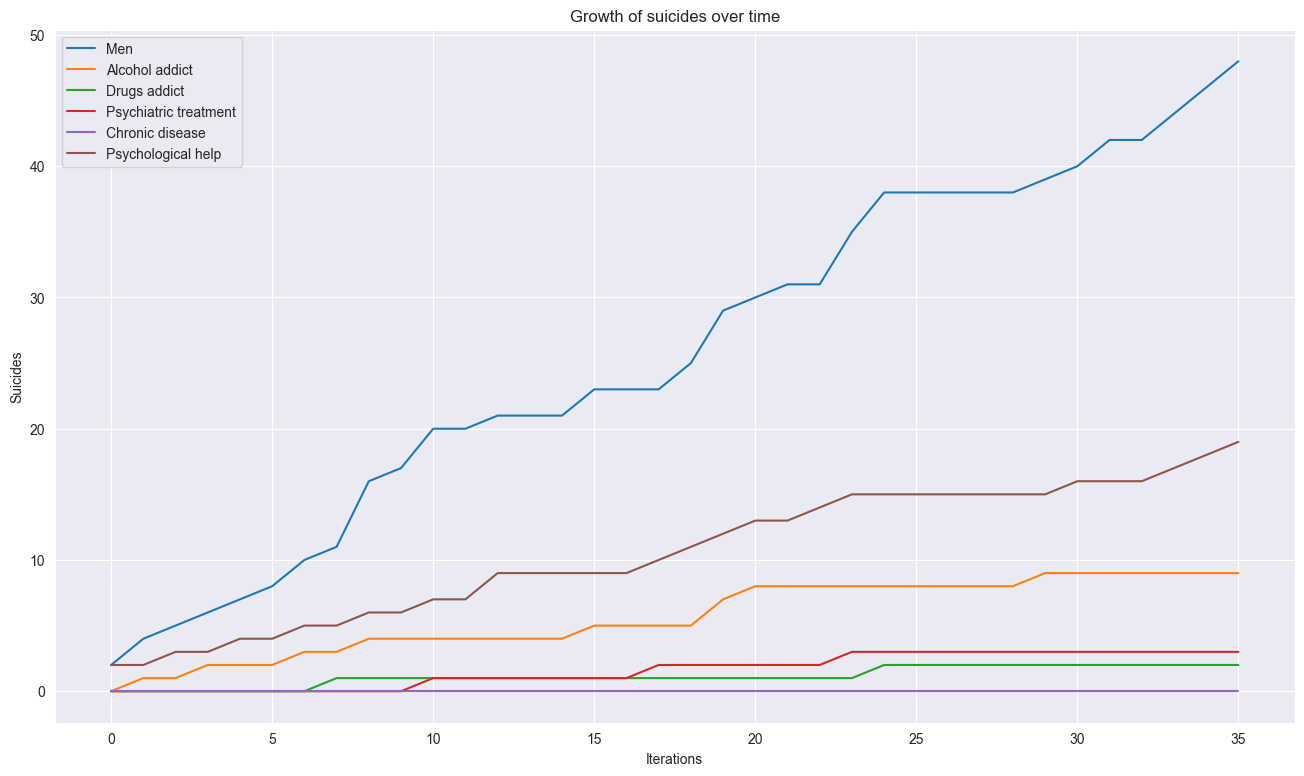

In [52]:
# row is a number of suicides from start to t
# without celebirty
suicides_cumsum = np.cumsum(world_suiciders, axis=0)

# Plot each column as a separate line
plt.figure(figsize=(16, 9))
column_labels = ['Men', 'Alcohol addict', 'Drugs addict', 'Psychiatric treatment', 'Chronic disease', 'Psychological help']

for col in range(suicides_cumsum.shape[1]-1):
    plt.plot(suicides_cumsum[:, col], label=column_labels[col])

# Labels and legend
plt.xlabel("Iterations")
plt.ylabel("Suicides")
plt.title("Growth of suicides over time")
plt.legend()

# Show the plot
plt.show()